In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.svm import SVC
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [24]:
df = pd.read_csv('survey_physical_activity.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   ID                           250 non-null    int64 
 1   Age                          250 non-null    object
 2   Gender                       250 non-null    object
 3   Ethnicity                    250 non-null    object
 4   Education Level              250 non-null    object
 5   General Health               250 non-null    object
 6   Fruits_Veg_Servings_Per_Day  179 non-null    object
 7   Physical_Activity_Per_Week   250 non-null    object
 8   Chronic_Diseases             250 non-null    object
 9   Physical_Activity_Level      250 non-null    object
dtypes: int64(1), object(9)
memory usage: 19.7+ KB


In [25]:
df.drop('ID', inplace=True, axis=1)

In [26]:

def extract_age(age_str):
    return int(age_str.split()[0])

# Apply the function to the 'Age' column
df['Age'] = df['Age'].apply(extract_age)

In [27]:
df.columns

Index(['Age', 'Gender', 'Ethnicity', 'Education Level', 'General Health',
       'Fruits_Veg_Servings_Per_Day', 'Physical_Activity_Per_Week',
       'Chronic_Diseases', 'Physical_Activity_Level'],
      dtype='object')

In [28]:
df.head(10)

,Age,Gender,Ethnicity,Education Level,General Health,Fruits_Veg_Servings_Per_Day,Physical_Activity_Per_Week,Chronic_Diseases,Physical_Activity_Level
0,39,Male,Ethnicity C,Master's,Poor,5 or more servings,1-2 days,Yes,Very active; physical activity is my daily rou...
1,31,Male,Ethnicity B,PhD,Good,1-2 servings,Not at all,No,Very active; physical activity is my daily rou...
2,57,Male,Ethnicity B,Master's,Good,NaN,5 or more days,Prefer not to say,Very active; physical activity is my daily rou...
3,61,Female,Ethnicity D,High School,Poor,NaN,1-2 days,Yes,Very active; physical activity is my daily rou...
4,41,Male,Ethnicity A,Bachelor's,Fair,NaN,Not at all,Yes,Very active; physical activity is my daily rou...
5,28,Female,Ethnicity C,High School,Fair,5 or more servings,1-2 days,No,Very active; physical activity is my daily rou...
6,59,Female,Ethnicity A,PhD,Good,5 or more servings,5 or more days,Prefer not to say,Very active; physical activity is my daily rou...
7,47,Female,Ethnicity A,High School,Poor,NaN,Not at all,Prefer not to say,Very active; physical activity is my daily rou...
8,20,Female,Ethnicity A,High School,Excellent,NaN,5 or more days,Yes,Very active; physical activity is my daily rou...
9,20,Female,Ethnicity C,Master's,Fair,5 or more servings,3-4 days,Yes,Very active; physical activity is my daily rou...


In [29]:
df['General Health'].value_counts()

General Health
Good         55
Poor         54
Very good    54
Excellent    47
Fair         40
Name: count, dtype: int64

In [30]:
# Encoding dictionary
encoding = {
    'Excellent': 4,
    'Very good': 3,
    'Good': 2,
    'Fair': 1,
    'Poor': 0
}

# Apply encoding to the 'General Health' column
df['General Health'] = df['General Health'].map(encoding)


In [31]:
df.head(10)

,Age,Gender,Ethnicity,Education Level,General Health,Fruits_Veg_Servings_Per_Day,Physical_Activity_Per_Week,Chronic_Diseases,Physical_Activity_Level
0,39,Male,Ethnicity C,Master's,0,5 or more servings,1-2 days,Yes,Very active; physical activity is my daily rou...
1,31,Male,Ethnicity B,PhD,2,1-2 servings,Not at all,No,Very active; physical activity is my daily rou...
2,57,Male,Ethnicity B,Master's,2,NaN,5 or more days,Prefer not to say,Very active; physical activity is my daily rou...
3,61,Female,Ethnicity D,High School,0,NaN,1-2 days,Yes,Very active; physical activity is my daily rou...
4,41,Male,Ethnicity A,Bachelor's,1,NaN,Not at all,Yes,Very active; physical activity is my daily rou...
5,28,Female,Ethnicity C,High School,1,5 or more servings,1-2 days,No,Very active; physical activity is my daily rou...
6,59,Female,Ethnicity A,PhD,2,5 or more servings,5 or more days,Prefer not to say,Very active; physical activity is my daily rou...
7,47,Female,Ethnicity A,High School,0,NaN,Not at all,Prefer not to say,Very active; physical activity is my daily rou...
8,20,Female,Ethnicity A,High School,4,NaN,5 or more days,Yes,Very active; physical activity is my daily rou...
9,20,Female,Ethnicity C,Master's,1,5 or more servings,3-4 days,Yes,Very active; physical activity is my daily rou...


In [32]:
df['Fruits_Veg_Servings_Per_Day'].value_counts(dropna=False)

Fruits_Veg_Servings_Per_Day
NaN                   71
1-2 servings          63
3-4 servings          59
5 or more servings    57
Name: count, dtype: int64

In [33]:
df['Ethnicity'].value_counts()

Ethnicity
Ethnicity A    71
Ethnicity C    69
Ethnicity D    63
Ethnicity B    47
Name: count, dtype: int64

In [34]:
df.loc[df["Gender"] == "Male", "Gender"] = 1
df.loc[df["Gender"] == "Female", "Gender"] = 0
df = df[df['Gender'] != 'Other']



In [35]:
df['Chronic_Diseases'].value_counts()

Chronic_Diseases
Prefer not to say    90
Yes                  85
No                   71
Name: count, dtype: int64

In [36]:
df['Physical_Activity_Level' ].value_counts()

Physical_Activity_Level
Very active; physical activity is my daily routine        245
Rarely active; I seldom engage in physical activities.      1
Name: count, dtype: int64

In [37]:
df['Physical_Activity_Per_Week' ].value_counts(dropna=False)

Physical_Activity_Per_Week
1-2 days          64
Not at all        61
5 or more days    61
3-4 days          60
Name: count, dtype: int64

/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_12390/140224540.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Fruits_Veg_Servings_Per_Day'].replace("NaN", "No response", inplace=True)
/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_12390/140224540.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which

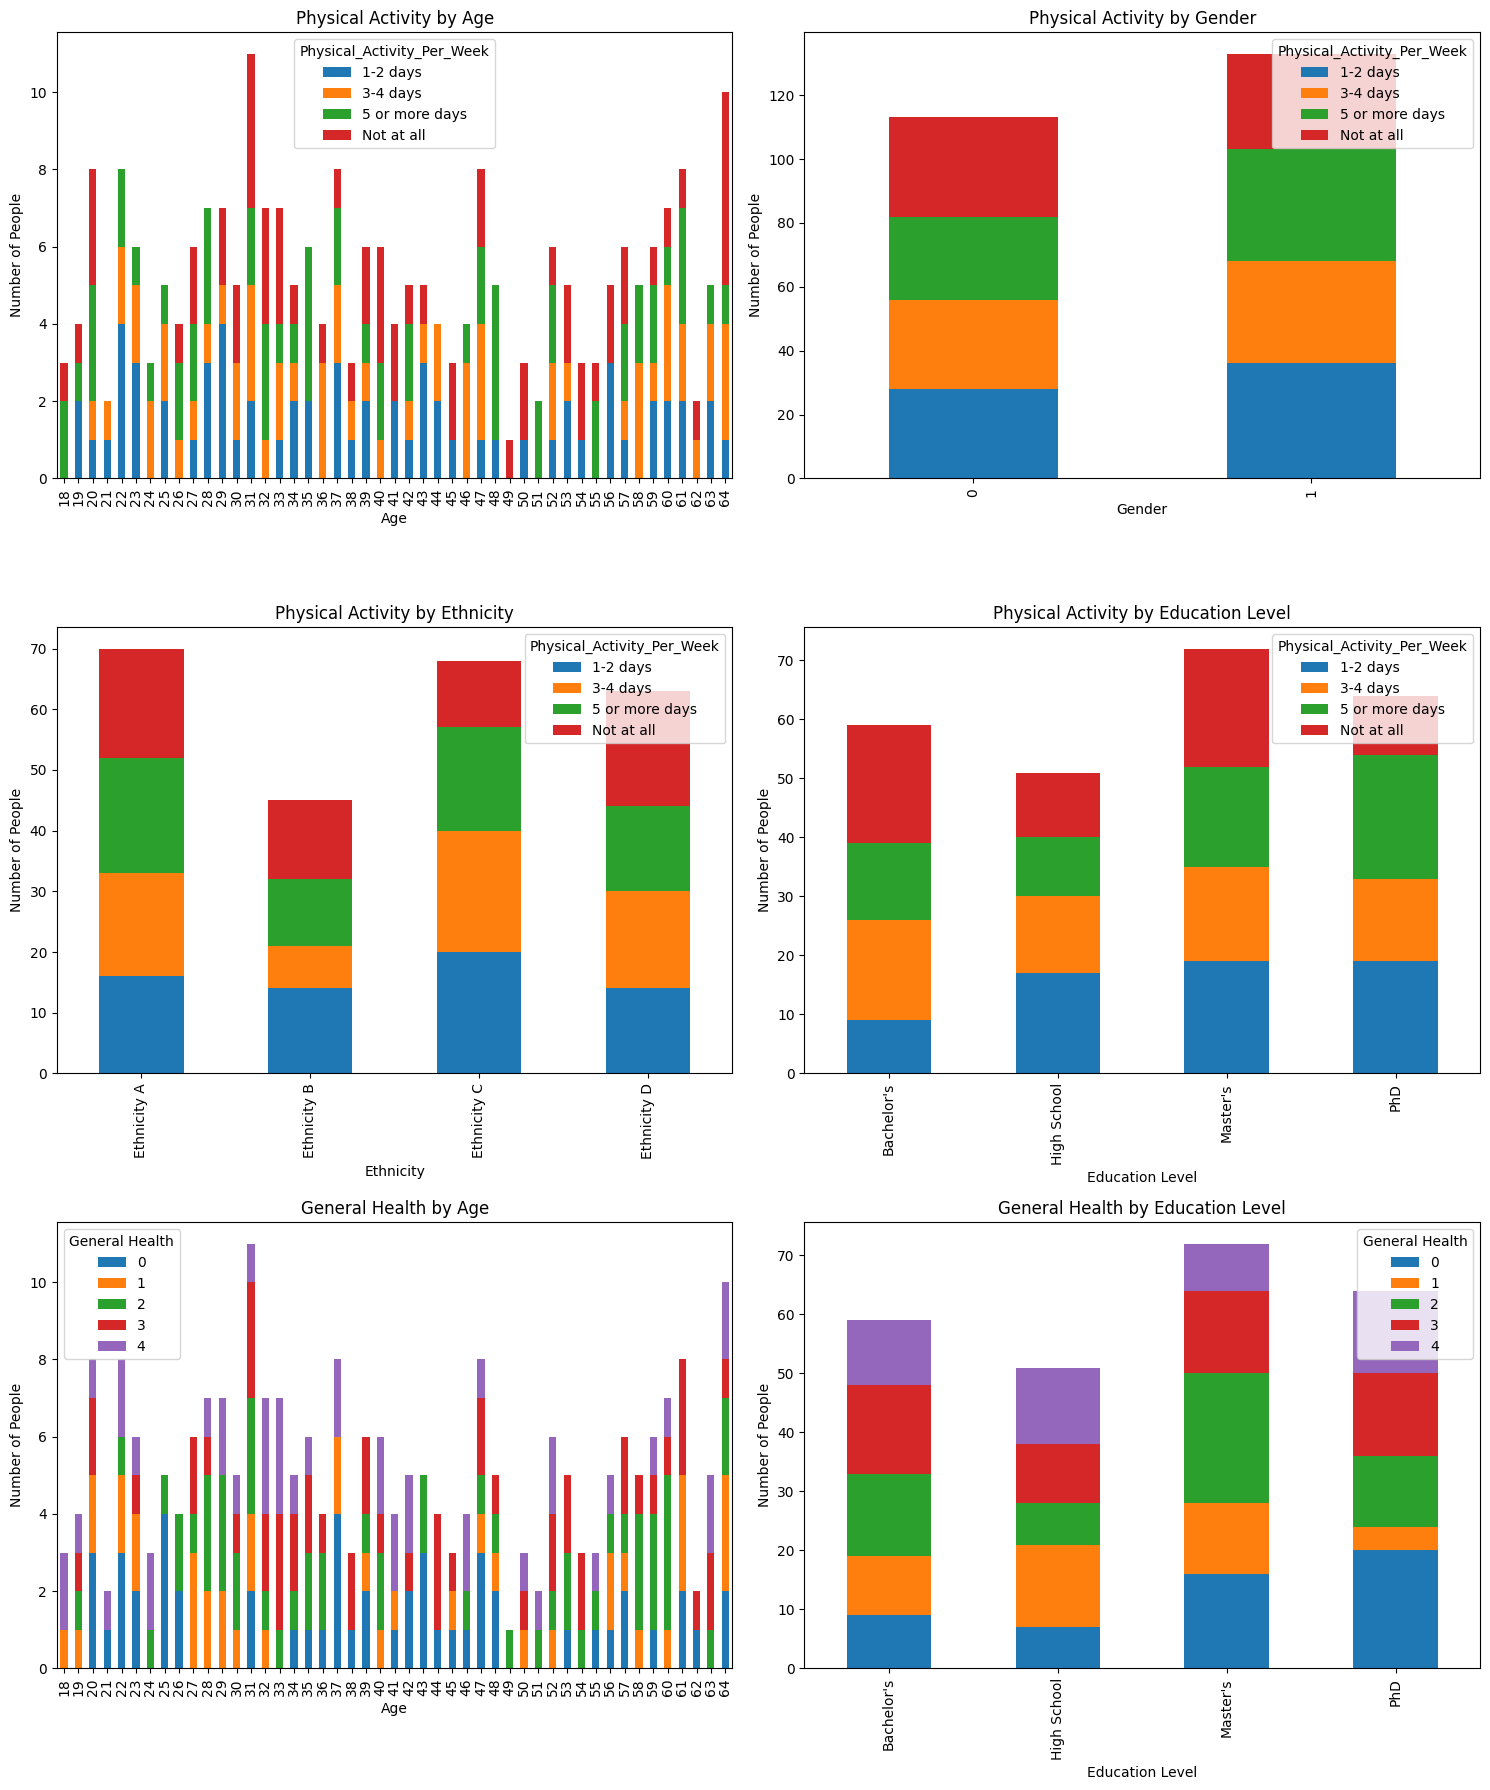

In [38]:
df['Fruits_Veg_Servings_Per_Day'].replace("NaN", "No response", inplace=True)
df['Physical_Activity_Per_Week'].replace("NaN", "No response", inplace=True)

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))

# Plotting Physical Activity by Age
df.groupby('Age')['Physical_Activity_Per_Week'].value_counts().unstack().plot(kind='bar', stacked=True, ax=axes[0,0])
axes[0,0].set_title('Physical Activity by Age')
axes[0,0].set_ylabel('Number of People')

# Plotting Physical Activity by Gender
df.groupby('Gender')['Physical_Activity_Per_Week'].value_counts().unstack().plot(kind='bar', stacked=True, ax=axes[0,1])
axes[0,1].set_title('Physical Activity by Gender')
axes[0,1].set_ylabel('Number of People')

# Plotting Physical Activity by Ethnicity
df.groupby('Ethnicity')['Physical_Activity_Per_Week'].value_counts().unstack().plot(kind='bar', stacked=True, ax=axes[1,0])
axes[1,0].set_title('Physical Activity by Ethnicity')
axes[1,0].set_ylabel('Number of People')

# Plotting Physical Activity by Education Level
df.groupby('Education Level')['Physical_Activity_Per_Week'].value_counts().unstack().plot(kind='bar', stacked=True, ax=axes[1,1])
axes[1,1].set_title('Physical Activity by Education Level')
axes[1,1].set_ylabel('Number of People')

# Plotting General Health by Age
df.groupby('Age')['General Health'].value_counts().unstack().plot(kind='bar', stacked=True, ax=axes[2,0])
axes[2,0].set_title('General Health by Age')
axes[2,0].set_ylabel('Number of People')

# Plotting General Health by Education Level
df.groupby('Education Level')['General Health'].value_counts().unstack().plot(kind='bar', stacked=True, ax=axes[2,1])
axes[2,1].set_title('General Health by Education Level')
axes[2,1].set_ylabel('Number of People')

plt.tight_layout()
plt.show()

In [39]:
# Visualize whether a person has chronic disease or not regarding their Physical_Activity_Per_Week
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Physical_Activity_Per_Week', hue='Chronic_Diseases')
plt.title('Chronic Diseases vs Physical Activity Per Week')
plt.xlabel('Physical Activity Per Week')
plt.ylabel('Count')
plt.legend(title='Chronic Diseases')
plt.xticks(rotation=45)
plt.tight_layout()

# Save and display the plot
plt.savefig('chronic_diseases_vs_physical_activity.png')
plt.show()

NameError: name 'sns' is not defined

<Figure size 1000x600 with 0 Axes>

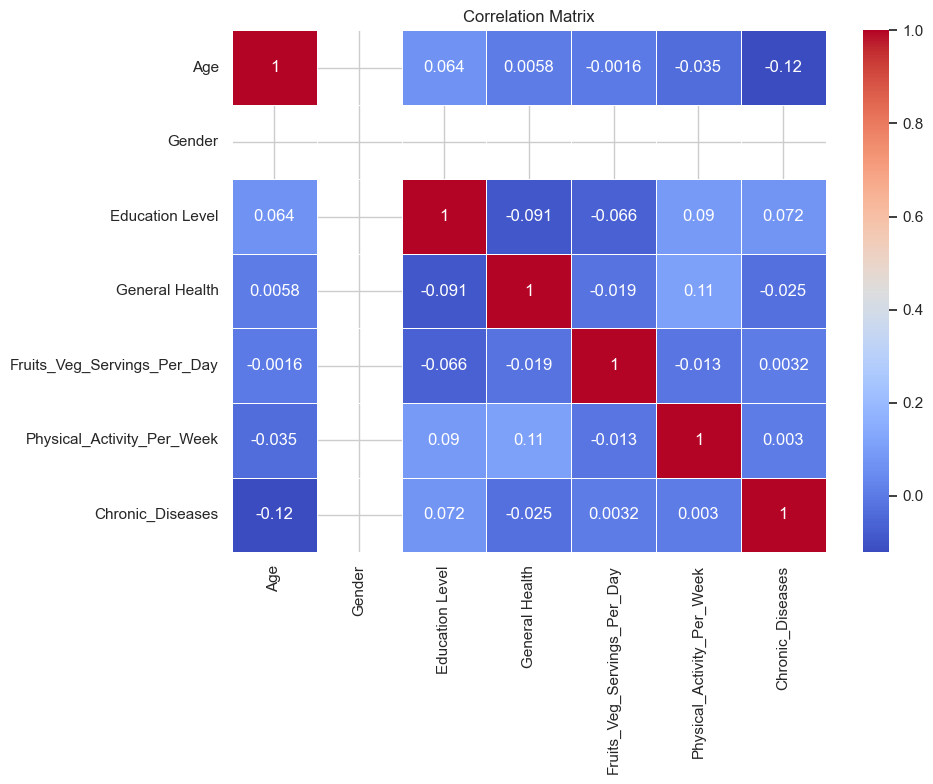

In [ ]:
df_encoded = df.copy()
df_encoded['Gender'] = df_encoded['Gender'].map({'Male': 0, 'Female': 1})
df_encoded['Chronic_Diseases'] = df_encoded['Chronic_Diseases'].map({'Yes': 1, 'No': 0, 'Prefer not to say': 2})
df_encoded['Physical_Activity_Per_Week'] = df_encoded['Physical_Activity_Per_Week'].map({
    'Not at all': 0, '1-2 days': 1, '3-4 days': 2, '5 or more days': 3
})
df_encoded['General Health'] = df_encoded['General Health'].map({
    'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3
})
df_encoded['Fruits_Veg_Servings_Per_Day'] = df_encoded['Fruits_Veg_Servings_Per_Day'].map({
    'None': 0, '1-2 servings': 1, '5 or more servings': 2
})
df_encoded['Education Level'] = df_encoded['Education Level'].map({
    'High School': 0, "Bachelor's": 1, "Master's": 2, 'PhD': 3
})

# Dropping columns that cannot be encoded easily
df_encoded.drop(['Ethnicity', 'Physical_Activity_Level'], axis=1, inplace=True)

# Creating the correlation matrix
corr_matrix = df_encoded.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()

# Save and display the plot
plt.savefig('correlation_matrix.png')
plt.show()

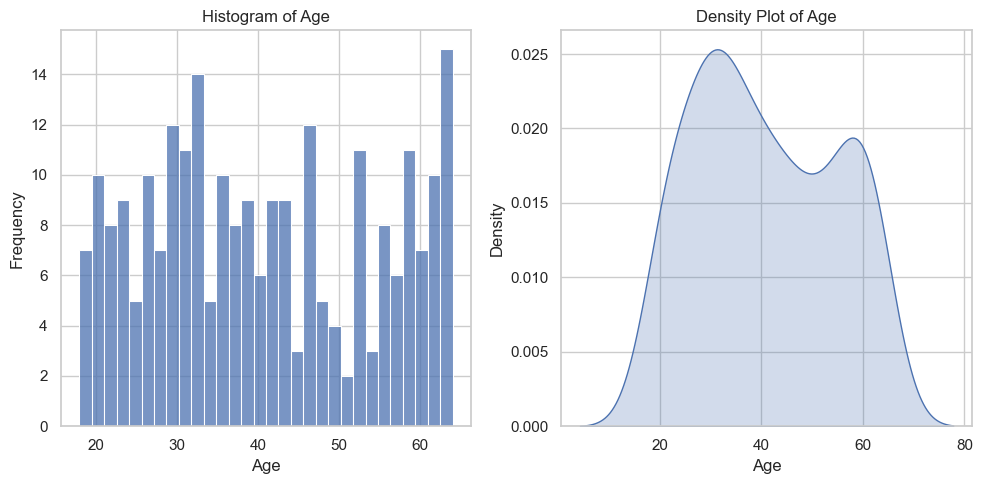

Statistics for Age:
count    246.000000
mean      40.731707
std       13.806874
min       18.000000
25%       29.000000
50%       39.000000
75%       53.000000
max       64.000000
Name: Age, dtype: float64

Skewness: 0.1599161704438204

Kurtosis: -1.2230342773061007




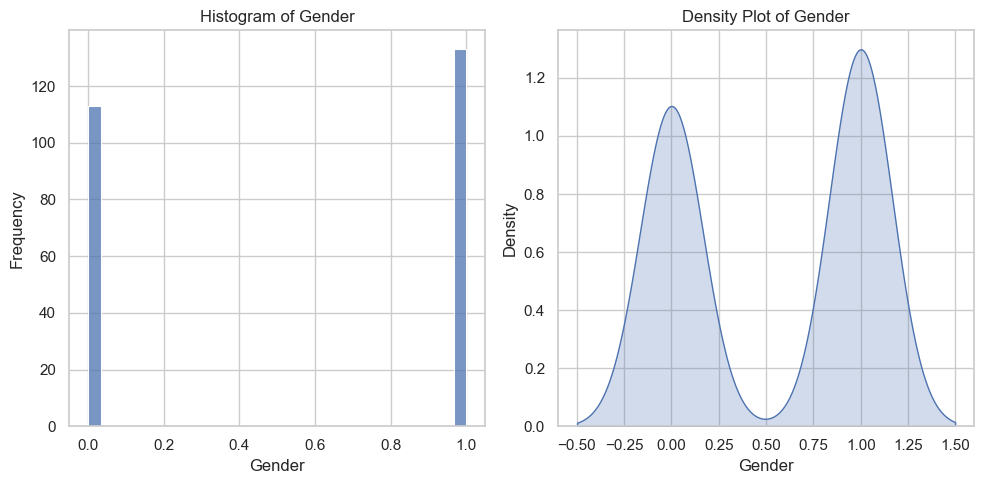

Statistics for Gender:
count     246
unique      2
top         1
freq      133
Name: Gender, dtype: int64

Skewness: -0.164144268485483

Kurtosis: -1.989296710027886




TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

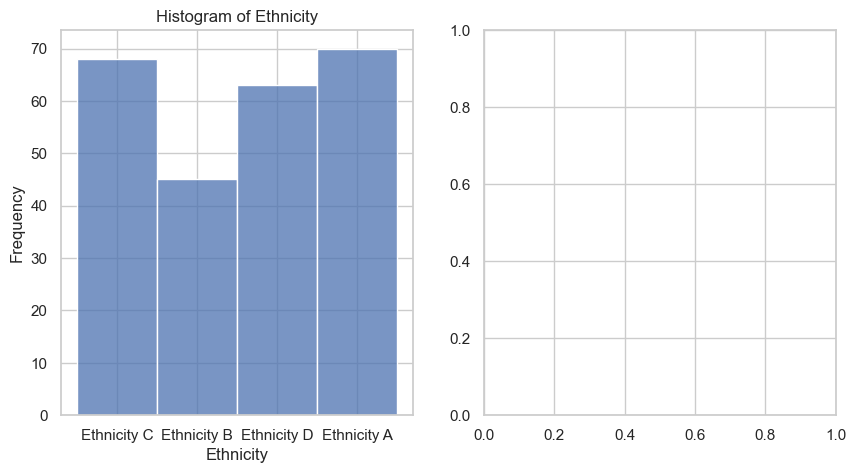

In [ ]:
import seaborn as sns

# Set the style of seaborn plots
sns.set_theme(style="whitegrid")

# Function to plot distribution of each column
def plot_distributions(df):
    for column in df.columns:
        plt.figure(figsize=(10, 5))
        
        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=False, bins=30)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
        # Density plot (KDE)
        plt.subplot(1, 2, 2)
        sns.kdeplot(df[column], fill=True)
        plt.title(f'Density Plot of {column}')
        plt.xlabel(column)
        plt.ylabel('Density')
        
        plt.tight_layout()
        plt.show()
        
        # Display basic statistics
        print(f'Statistics for {column}:')
        print(df[column].describe())
        print('\nSkewness:', df[column].skew())
        print('\nKurtosis:', df[column].kurtosis())
        print('\n')

# Plot distributions
plot_distributions(df)


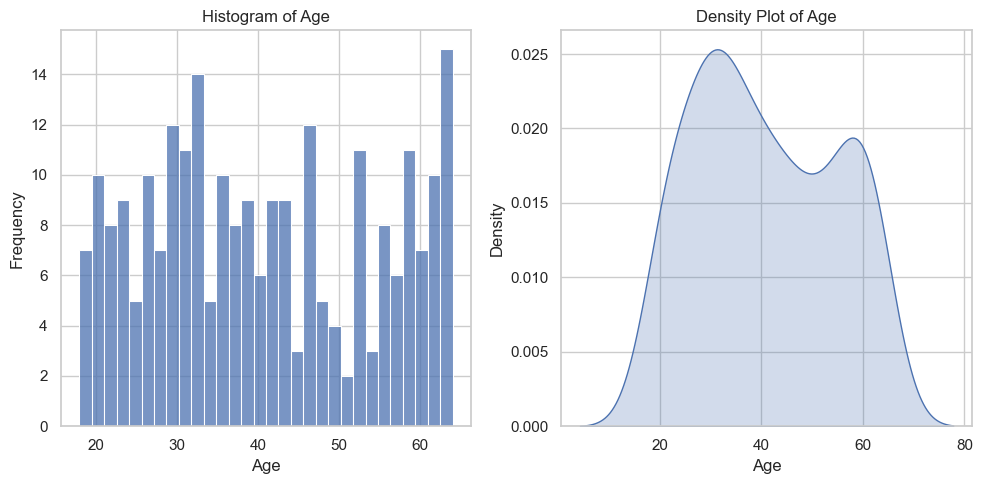

Statistics for Age:
count    246.000000
mean      40.731707
std       13.806874
min       18.000000
25%       29.000000
50%       39.000000
75%       53.000000
max       64.000000
Name: Age, dtype: float64

Skewness: 0.1599161704438204

Kurtosis: -1.2230342773061007




/var/folders/1h/20qwddgj29lghmzyjxl8m6k80000gn/T/ipykernel_3522/2194515284.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[column], fill=True)


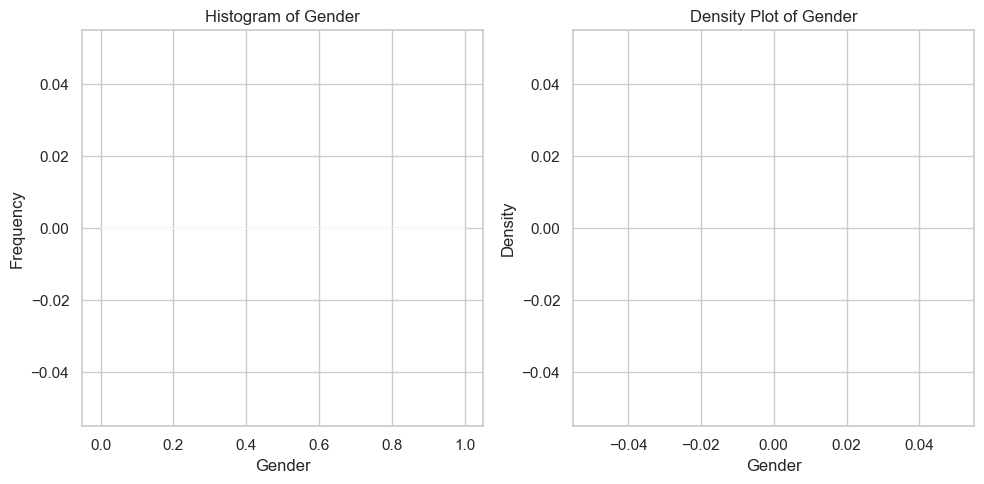

Statistics for Gender:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Gender, dtype: float64

Skewness: nan

Kurtosis: nan




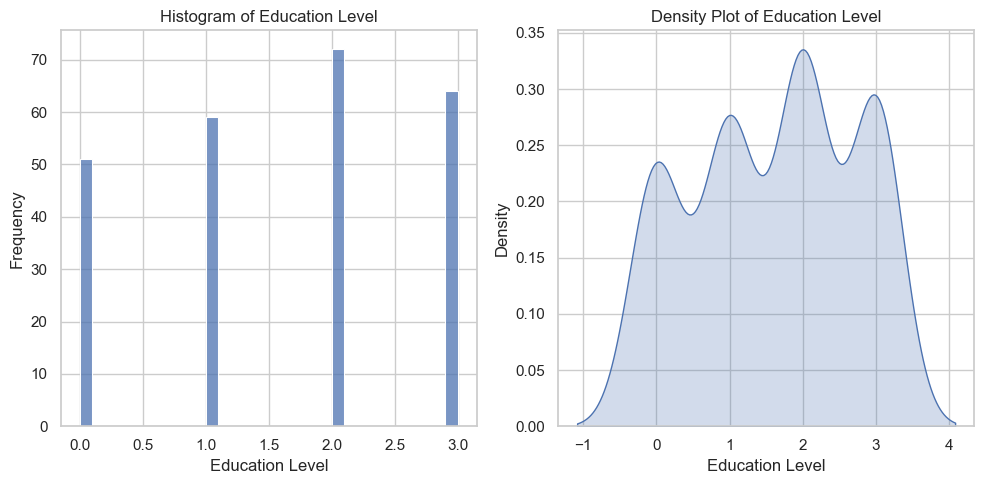

Statistics for Education Level:
count    246.000000
mean       1.605691
std        1.085624
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        3.000000
Name: Education Level, dtype: float64

Skewness: -0.1490570811903135

Kurtosis: -1.2586689925739125




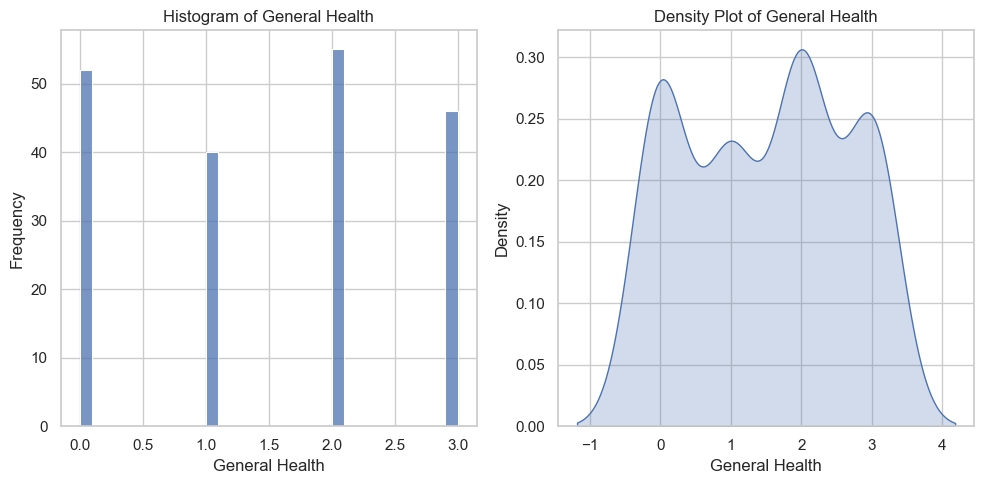

Statistics for General Health:
count    193.000000
mean       1.492228
std        1.127863
min        0.000000
25%        0.000000
50%        2.000000
75%        2.000000
max        3.000000
Name: General Health, dtype: float64

Skewness: -0.046513714861440104

Kurtosis: -1.3817938700505001




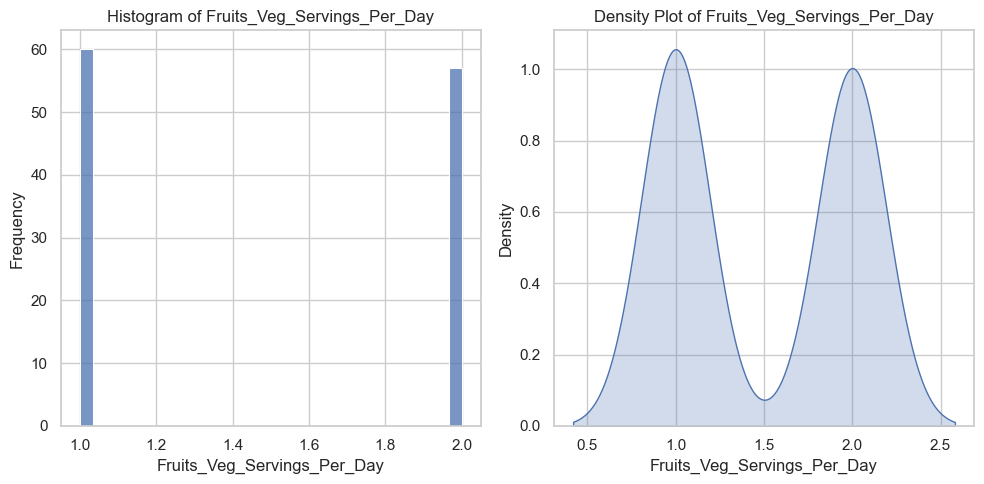

Statistics for Fruits_Veg_Servings_Per_Day:
count    117.000000
mean       1.487179
std        0.501985
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: Fruits_Veg_Servings_Per_Day, dtype: float64

Skewness: 0.05196755529465591

Kurtosis: -2.0323401180296274




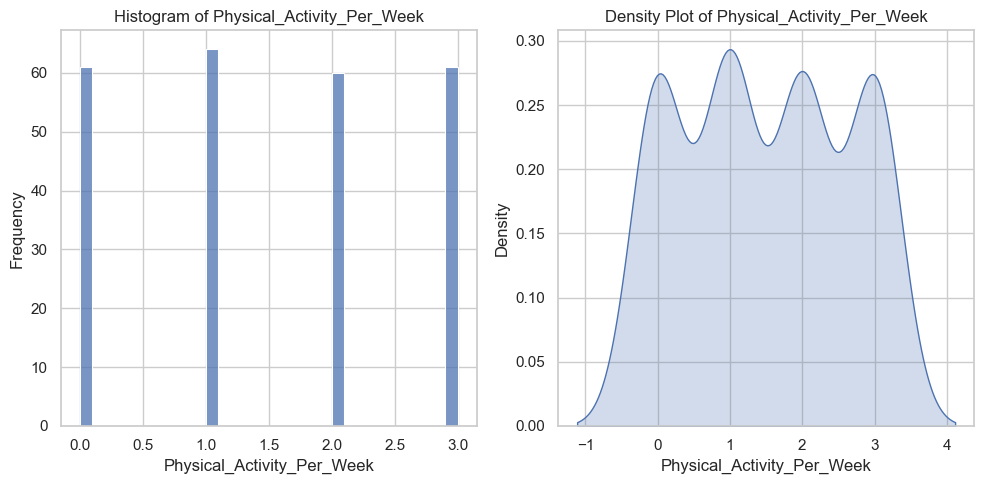

Statistics for Physical_Activity_Per_Week:
count    246.000000
mean       1.491870
std        1.116634
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: Physical_Activity_Per_Week, dtype: float64

Skewness: 0.02054426740446817

Kurtosis: -1.354261679372068




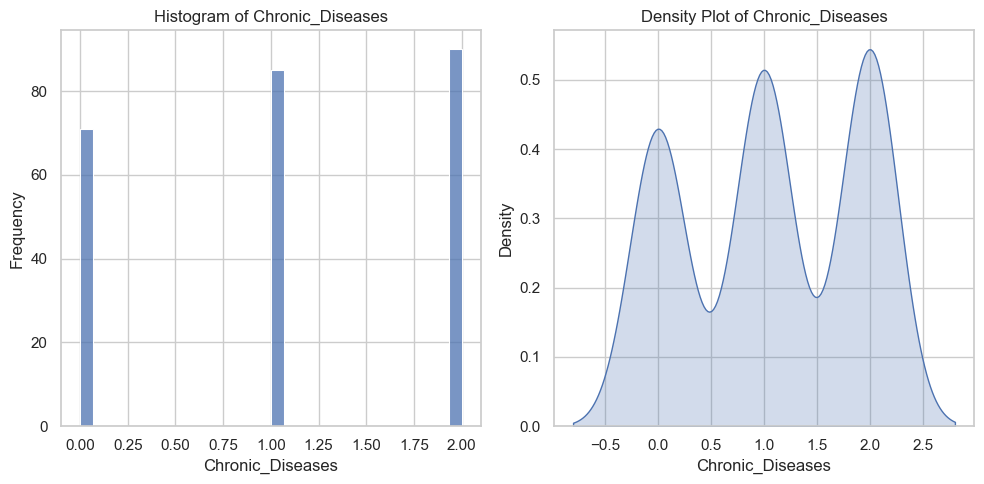

Statistics for Chronic_Diseases:
count    246.000000
mean       1.077236
std        0.806941
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: Chronic_Diseases, dtype: float64

Skewness: -0.1415824850442577

Kurtosis: -1.450117218918812




In [ ]:
sns.set_theme(style="whitegrid")

# Function to plot distribution of each column
def plot_distributions(df):
    for column in df.columns:
        plt.figure(figsize=(10, 5))
        
        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[column], kde=False, bins=30)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        
        # Density plot (KDE)
        plt.subplot(1, 2, 2)
        sns.kdeplot(df[column], fill=True)
        plt.title(f'Density Plot of {column}')
        plt.xlabel(column)
        plt.ylabel('Density')
        
        plt.tight_layout()
        plt.show()
        
        # Display basic statistics
        print(f'Statistics for {column}:')
        print(df[column].describe())
        print('\nSkewness:', df[column].skew())
        print('\nKurtosis:', df[column].kurtosis())
        print('\n')

# Plot distributions for the encoded DataFrame
plot_distributions(df_encoded)

In [ ]:
df.dropna(subset=['Physical_Activity_Level'], inplace=True)

In [42]:
import pandas as pd
import sweetviz as sv
from collections import Counter
from fairlearn.metrics import MetricFrame
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load data

# Quick overview with Sweetviz
report = sv.analyze(df)
report.show_html('sweetviz_report.html')

# Check class imbalance
print("Class distribution:", Counter(df['target']))

# Train a simple model (example with RandomForest)
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Bias detection with Fairlearn
metric_frame = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=df['gender'])
print("Accuracy by group:", metric_frame.by_group)

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


KeyError: "['target'] not found in axis"